<b> В задании нужно загрузить датасет с данными оттока и ответить на несколько вопросов (написать код). При этом сам датасет уже есть и его необязательно качать с репозитория</b>

Цель задания: проверить базовые навыки работы студентов с Pandas, умение проводить такой же базовый EDA (exploratory data analysis), делать feature engineering и обучать и валидировать модель.

In [334]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold 

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

import time

pd.set_option("display.max_rows", 6)

import warnings
warnings.filterwarnings('ignore')

In [335]:
data = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [336]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


##### 1. Какое соотношение мужчин и женщин в представленном наборе данных?

In [337]:
df.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Признак пола у данных сбалансирован

##### 2. Какое количество уникальных значений у поля InternetService?

In [338]:
df.InternetService.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

##### 3. Выведите статистики по полю TotalCharges (median, mean, std).

Сначала перекодируем тип данных колонки из объекта в дробь:

In [339]:
df.TotalCharges = df['TotalCharges'].convert_dtypes()
df.TotalCharges = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [340]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


Здесь нет медианы, но среднее и отклонение видно.<br>
Медиану и среднее можно еще найти так и визуализировать:


In [341]:
def desc_info(column):
    column_mean = round(column.mean(), 2)
    column_median = column.median()
    column_std = column.std(ddof=1)
    return column_mean, column_median, column_std

TotalCharges_mean, TotalCharges_median, TotalCharges_std = desc_info(df['TotalCharges'])

TotalCharges_mean, TotalCharges_median, TotalCharges_std

(2283.3, 1397.475, 2266.7713618831453)

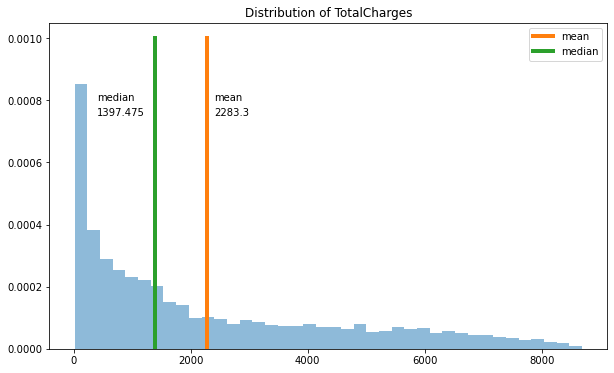

In [342]:
plt.figure(figsize = (10, 6))
plt.hist(df['TotalCharges'], density=True, bins=40, alpha=0.5)

y = np.linspace(0, 0.001, 10)   # второй параметр 0.8 нужно перебирать чтобы рисовались прямые

plt.plot([TotalCharges_mean] * 10, y, label='mean',  linewidth=4)
plt.text(2400, 0.0008, 'mean')
plt.text(2400, 0.00075, TotalCharges_mean)

plt.plot([TotalCharges_median] * 10, y, label='median',  linewidth=4)
plt.text(400, 0.0008, 'median')
plt.text(400, 0.00075, TotalCharges_median)

plt.title('Distribution of TotalCharges')
plt.legend()
plt.show()

В чем странность того, что вы получили? (подсказка: смотреть нужно на тип данных)

Не заметил странностей

##### 4. Сделайте замену значений поля PhoneService  на числовые (Yes->1, No->0)

In [343]:
df.PhoneService = df.PhoneService.replace("Yes", 1)
df.PhoneService = df.PhoneService.replace("No", 0)


Проверям результат, видим что тип данных и сами данные изменились:

In [344]:
df.PhoneService 

0       0
1       1
2       1
       ..
7040    0
7041    1
7042    1
Name: PhoneService, Length: 7043, dtype: int64

Попробуем и другой способ, вернем сначала все обратно:

In [345]:
df.PhoneService = data.PhoneService

In [346]:
df.PhoneService = np.where((df.PhoneService == 'Yes'), 1, 0)
df.PhoneService

0       0
1       1
2       1
       ..
7040    0
7041    1
7042    1
Name: PhoneService, Length: 7043, dtype: int64

##### 5. Сделайте замену пробелов в поле TotalCharges на np.nan и приведите поле к типу данных float32. Затем заполните оставшиеся пропуски значением 0 с помощью метода fillna у столбца. Снова выведите статистики и сравните с тем, что вы видели в вопросе 3

Замены делал ранее, посмотрим где вообще есть пропуски:

In [347]:
pd.set_option("display.max_rows", 21)

len(df) - df.count()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Видим что пропуски только в колонке TotalCharges, посмотрим их внимательнее:

In [348]:
pd.set_option("display.max_rows", 6)

df[pd.isnull(df.TotalCharges)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,0,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,1,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,1,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,2923-ARZLG,Male,0,Yes,Yes,0,1,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,1,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
6754,2775-SEFEE,Male,0,No,Yes,0,1,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


Заменяем:

In [349]:
df.TotalCharges.fillna(0, inplace=True)
df[pd.isnull(df.TotalCharges)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Пропусков больше нет, проверим статистику:

In [350]:
print(f'Было до обработки пропусков:\nmean {TotalCharges_mean},\nmedian {TotalCharges_median},\n\
std {TotalCharges_std}')

Было до обработки пропусков:
mean 2283.3,
median 1397.475,
std 2266.7713618831453


Смотрим как стало:

In [351]:
TotalCharges_mean, TotalCharges_median, TotalCharges_std = desc_info(df['TotalCharges'])

print(f'Стало:\nmean {TotalCharges_mean},\nmedian {TotalCharges_median},\n\
std {TotalCharges_std}')


Стало:
mean 2279.73,
median 1394.55,
std 2266.7944696890195


##### 6. Сделайте замену значений поля Churn на числовые (Yes -> 1, No - 0)

In [352]:
df.Churn = np.where((df.Churn == 'Yes'), 1, 0)
df.Churn 

0       0
1       0
2       1
       ..
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

##### 7. Сделайте замену значений полей StreamingMovies, StreamingTV, TechSupport  на числовые (Yes -> 1, No -> 0, No internet service->0)

Посмотрим что в этих колонках:

In [353]:
df.loc[:, ['StreamingMovies', 'StreamingTV', 'TechSupport']]

,StreamingMovies,StreamingTV,TechSupport
0,No,No,No
1,No,No,No
2,No,No,No
...,...,...,...
7040,No,No,No
7041,No,No,No
7042,Yes,Yes,Yes


In [354]:
df.loc[:, ['StreamingMovies', 'StreamingTV', 'TechSupport']].info

<bound method DataFrame.info of      StreamingMovies StreamingTV TechSupport
0                 No          No          No
1                 No          No          No
2                 No          No          No
...              ...         ...         ...
7040              No          No          No
7041              No          No          No
7042             Yes         Yes         Yes

[7043 rows x 3 columns]>

In [355]:
def replace_bool(columns_name):
    for i in columns_name:
        df[i] = np.where((df[i] == 'Yes'), 1, 0)
        
replace_bool(['StreamingMovies', 'StreamingTV', 'TechSupport'])

Проверяем:

In [356]:
df.loc[:, ['StreamingMovies', 'StreamingTV', 'TechSupport']]

,StreamingMovies,StreamingTV,TechSupport
0,0,0,0
1,0,0,0
2,0,0,0
...,...,...,...
7040,0,0,0
7041,0,0,0
7042,1,1,1


##### 8. Заполните пропуски в поле PhoneService значением 0

В колонке PhoneService не было пропусков, выше видели

#### 8. Для нашего датасета оставьте только указанный ниже список полей, удалив все другие и выведите верхние 3 строки

In [357]:
columns = ['gender', 'tenure', 'PhoneService', 'TotalCharges', 
           'StreamingMovies', 'StreamingTV', 'TechSupport', 'Churn']

for i in list(df.columns):
    if i not in columns:
        df.drop(i, axis=1, inplace=True) 

df.head(3)   

,gender,tenure,PhoneService,TechSupport,StreamingTV,StreamingMovies,TotalCharges,Churn
0,Female,1,0,0,0,0,29.85,0
1,Male,34,1,0,0,0,1889.50,0
2,Male,2,1,0,0,0,108.15,1


##### 9. Разделите датасет на тренировочную и тестовую выборку (подсказка - воспользуйтесь train_test_split из sklearn.model_selection. Ссылка - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [358]:
features = ['gender', 'tenure', 'PhoneService', 'TotalCharges', 'StreamingMovies', 'StreamingTV', 'TechSupport']
target = 'Churn'

X = df.loc[:, features]
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)


##### 10. соберите pipeline для поля gender (нужно разобраться и изучить https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html ) из классов ColumnSelector и OHEEncoder, которые уже написаны ниже заранее

In [359]:
from sklearn.base import BaseEstimator, TransformerMixin


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

gender = Pipeline([
                ('selector', ColumnSelector(key='gender')),
                ('ohe', OHEEncoder(key='gender'))
            ])

##### 11. Вызовите метод fit_transform у пайплайна gender и передайте туда нашу тренировочную выборку (пример по ссылке из документации https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.fit)

In [360]:
gender.fit_transform(X_train, y_train)


,gender_Female,gender_Male
6463,0,1
289,0,1
4356,1,0
...,...,...
3980,0,1
235,0,1
5157,1,0


In [361]:
gender

Pipeline(steps=[('selector', ColumnSelector(key='gender')),
                ('ohe', OHEEncoder(key='gender'))])

##### 12. Здесь код писать уже не нужно (все сделано за вас). К полю tenure применяем StandardScaler (нормируем и центрируем). Ссылка - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
Вопрос - в каких случаях это может быть полезно?

In [362]:
tenure =  Pipeline([
                ('selector', NumberSelector(key='tenure')),
                ('standard', StandardScaler())
            ])

##### 13. Напишите аналогичный (как для tenure) преобразователь поля TotalCharges

In [363]:
total_charges =  Pipeline([
                ('selector', NumberSelector(key='TotalCharges')),
                ('standard', StandardScaler())
            ])


Объединение всех "кубиков" очень легко сделать таким образом

In [364]:
from sklearn.pipeline import FeatureUnion

number_features = Pipeline([
                ('selector', ColumnSelector(key=['PhoneService',
                                                 'StreamingMovies', 'StreamingTV', 
                                                 'TechSupport']))
            ])

In [365]:
feats = FeatureUnion([('tenure', tenure),
                      ('TotalCharges', total_charges),
                      ('continuos_features', number_features),
                      ('gender', gender)])

feature_processing = Pipeline([('feats', feats)])


На этом этапе что мы сделали:
1. написали преобразователь поля gender, который делает OHE кодирование
2. написали преобразователь для поля tenure, который нормирует и центрирует его 
3. повторили п. 2 для поля TotalCharges
3. для всех остальных просто взяли признаки как они есть, без изменений

У нас уже готов наш пайплайн, который преобразовывает признаки. Давайте обучим модель поверх него. В качестве модели возьмем RandomForestClassifier

In [366]:
X_train.shape, y_train.shape, X_test.shape

((5282, 7), (5282,), (1761, 7))

In [367]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 1)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tenure',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='tenure')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('TotalCharges',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='TotalCharges')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('continuos_features',
                                                 Pipeline(steps=[('selector',
          

##### 14. Сделайте прогноз вероятности оттока для X_test с помощью нашего предобученного на предыдущем шаге пайплайна и убедитесь что вам возвращаются вероятности для 2 классов

In [368]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

Посмотрим на баланс классов, чтобы опрелделить метрику.

In [369]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Видим явный дисбаланс, значит accuracy не подходит, при дисбалансе эффективной метрикой будет f-score

In [370]:
print(f'Train: {f1_score(y_train, pred_train)},\nTest: {f1_score(y_test, pred_test)}')

Train: 0.9870945238925706,
Test: 0.505938242280285


Модель требует настройки, т.к. на  лицо переобучение.

Далее проделаю ту же самую настройку МО по имеющимся в sklearn инструментам и сравню результат.

In [371]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           7043 non-null   object 
 1   tenure           7043 non-null   int64  
 2   PhoneService     7043 non-null   int64  
 3   TotalCharges     7043 non-null   float64
 4   StreamingMovies  7043 non-null   int64  
 5   StreamingTV      7043 non-null   int64  
 6   TechSupport      7043 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 385.3+ KB


Только пол нужно даммить, т.к. он объект

In [372]:
X = pd.get_dummies(X)
X

,tenure,PhoneService,TotalCharges,StreamingMovies,StreamingTV,TechSupport,gender_Female,gender_Male
0,1,0,29.85,0,0,0,1,0
1,34,1,1889.50,0,0,0,0,1
2,2,1,108.15,0,0,0,0,1
...,...,...,...,...,...,...,...,...
7040,11,0,346.45,0,0,0,1,0
7041,4,1,306.60,0,0,0,0,1
7042,66,1,6844.50,1,1,1,0,1


In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)


pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 1))
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])

In [374]:
pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

print(f'Train: {f1_score(y_train, pred_train)},\nTest: {f1_score(y_test, pred_test)}')

Train: 0.9870945238925706,
Test: 0.4957882069795427


Без подбора параметров получили примерно то же самое.

Подберем параметры:

In [375]:
# %%time

# params = {'randomforestclassifier__max_depth':[3, 5, 6, 7, 9],
#           'randomforestclassifier__min_samples_leaf': [2, 5, 7, 9, 12],          
#           'randomforestclassifier__max_features': [2,3,4,5,6],
#           'randomforestclassifier__criterion': ['gini', 'entropy'],
#           'randomforestclassifier__n_estimators': [10, 30, 50, 80, 100, 150]
#          }

# grid = GridSearchCV(pipe, params, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train)

#__________________________________________________________________
# CPU times: user 41.4 s, sys: 4.08 s, total: 45.4 s
# Wall time: 25min 21s
    
# grid.best_estimator_.named_steps["randomforestclassifier"].get_params(deep=True)

# {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'entropy',
#  'max_depth': 9,
#  'max_features': 6,
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 9,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 50,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 1,
#  'verbose': 0,
#  'warm_start': False}

In [376]:
params = {'criterion': 'entropy',
          'max_depth': 9,
          'max_features': 6,
          'min_samples_leaf': 9,
          'min_samples_split': 2,
          'n_estimators': 50,
          'random_state': 1
         }

pipe = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='entropy', max_depth=9, max_features=6,
          min_samples_leaf=9,min_samples_split=2,n_estimators=50, random_state=1))

pipe.fit(X_train, y_train)

pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

print(f'Train: {f1_score(y_train, pred_train)},\nTest: {f1_score(y_test, pred_test)}')

Train: 0.6146938775510203,
Test: 0.5204755614266843


Видим, что случайный лес на лучших гиперпараметрах выдает лучше, но по-прежнему плохой результат.


Значит дело в признаках, попробовать др. модели МО.

## Тестовый раздел

Перепишу в более читаемый вид пайплайны и местами объединю логику

In [378]:
from sklearn.preprocessing import OneHotEncoder

new_df = data.copy()
new_X = new_df.loc[:, features]

new_X.TotalCharges = df['TotalCharges'].convert_dtypes()
new_X.TotalCharges = pd.to_numeric(df['TotalCharges'], errors='coerce')
new_X.TotalCharges.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, random_state=1, test_size=0.25)

cat_feats = ['PhoneService', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'gender']
num_feats = ['tenure', 'TotalCharges']

# пайплайн обработки категориальных признаков
cat_pipe = Pipeline([
                ('selector', ColumnSelector(key=cat_feats)),
                ('ohe', OHEEncoder(key=cat_feats)) 
                    ])

# пайплайн обработки числовых признаков
num_pipe = Pipeline([
                ('selector', ColumnSelector(key=num_feats)),
                ('scaler', StandardScaler())
                    ])

# объединение двух пайплайнов в один процесс - вроде бы лишнее нагромаждение кода
feats = FeatureUnion([('numerical_features', num_pipe),
                      ('categorial_features', cat_pipe)
                     ])
                   

# пайплайн совмещающий препроцессинг и обучение модели МО
pipeline = Pipeline([('feats', feats),
                    ('classifier', LogisticRegression(random_state = 1))
                    ])
# на этом этапе происходим дамминг, масштабирование и обучение на преобр. данных модели МО
pipeline.fit(X_train, y_train)

# на этом этапе при предсказании не понял происходит ли преобразование тестовых данных
new_pred_train = pipeline.predict(X_train)
new_pred_test = pipeline.predict(X_test)

print(f'Train: {f1_score(y_train, new_pred_train)},\nTest: {f1_score(y_test, new_pred_test)}')

Train: 0.5567484662576687,
Test: 0.5479452054794521


Модель получилась не переобученная, но не эффективная.

Смысла ее улучшать нет, но потестить работу нашего сложного пайплайна в грид сече можно:

In [379]:
new_df = data.copy()
new_X = new_df.loc[:, features]
new_X.TotalCharges = df['TotalCharges'].convert_dtypes()
new_X.TotalCharges = pd.to_numeric(df['TotalCharges'], errors='coerce')
new_X.TotalCharges.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, random_state=1, test_size=0.25)


In [380]:
%%time


main_pipe = Pipeline([('preprocessing', feats),
                      ('classifier', LogisticRegression(random_state = 1))
                     ])

params_grid = {'classifier__random_state': [1],
               'classifier__C': [0.01, 0.1, 1, 10, 100],
               'classifier__max_iter': [50, 100, 200, 300, 500],
               'preprocessing__numerical_features__scaler': [MinMaxScaler(), StandardScaler()]
              }

grid = GridSearchCV(main_pipe, params_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

new_pred_train = grid.best_estimator_.predict(X_train)
new_pred_test = grid.best_estimator_.predict(X_test)

print(f'Train: {f1_score(y_train, new_pred_train)},\nTest: {f1_score(y_test, new_pred_test)}')

Train: 0.5550831078469268,
Test: 0.5470514429109159
CPU times: user 4.09 s, sys: 293 ms, total: 4.38 s
Wall time: 16.1 s


In [381]:
grid.best_estimator_.named_steps["classifier"].get_params(deep=True)

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [382]:
grid.best_estimator_.named_steps["preprocessing"]#.get_params(deep=True)

FeatureUnion(transformer_list=[('numerical_features',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(key=['tenure',
                                                                     'TotalCharges'])),
                                                ('scaler', StandardScaler())])),
                               ('categorial_features',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(key=['PhoneService',
                                                                     'StreamingMovies',
                                                                     'StreamingTV',
                                                                     'TechSupport',
                                                                     'gender'])),
                                                ('ohe',
                                          

Не понял как залезть внутрь FeatureUnion и обратиться к ключу 'scaler' - там интересует что лучше отработало МинМакc или СтандартСкал. 

Странно что модель с параметрами по умолчанию справилась чуть лучше с тестом, чем с улучшенными параметрами.

Попробуем сравнить разные модели:

In [383]:
%%time

params_grid = [{'classifier': [SVC()], 
                'classifier__random_state': [1],
                'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
               
               
              {'classifier': [LogisticRegression()],
               'classifier__random_state': [1],
               'classifier__penalty': ['l1', 'l2'],  
               'classifier__C': [0.01, 0.1, 1, 10, 100],
               'classifier__max_iter': [50, 100, 200, 300, 500],
               'classifier__solver': ['lbfgs', 'liblinear']},
               
               # по лесу лучшие параметры находил ранее, не стал по лесу заново искать, т.к. 25 мин было прошлый раз
               # да и не должно было сказаться на качетсве предобработка, т.к. лес к ней не чувствителен
               {'classifier': [RandomForestClassifier()],
                'classifier__criterion': ['entropy'],
                'classifier__max_depth': [9],
                'classifier__max_features': [6],
                'classifier__min_samples_leaf': [9],
                'classifier__min_samples_split': [2],
                'classifier__n_estimators': [50],
                'classifier__random_state': [1]
              }]
                


grid = GridSearchCV(main_pipe, params_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

new_pred_train = grid.best_estimator_.predict(X_train)
new_pred_test = grid.best_estimator_.predict(X_test)

print(f'Train: {f1_score(y_train, new_pred_train)},\nTest: {f1_score(y_test, new_pred_test)}')

Train: 0.5479787668436097,
Test: 0.5378590078328983
CPU times: user 16.4 s, sys: 337 ms, total: 16.7 s
Wall time: 3min 4s


In [388]:
grid.best_estimator_.named_steps["classifier"]

SVC(C=100, gamma=0.1, random_state=1)

Почему-то решетчатый поиск выдал SVC лучшей моделью при этом предсказания на тесте хуже.<br>
Возможно у него меньше переобучение.

А пока двигаемся дальше по вопросам

##### 15. Посчитайте метрики качества получившейся модели (roc_auc, logloss)

In [393]:
from sklearn.metrics import roc_auc_score, log_loss


auc_train = roc_auc_score(y_train, pred_train) # тянется предсказание с лучшей лесной модели
auc_test = roc_auc_score(y_test, pred_test)

auc_train, auc_test

(0.7283168295309528, 0.6794830166794578)

Посмотрим какие показатели у лучшей модели из гридсеча - SVC:

In [394]:
auc_train = roc_auc_score(y_train, grid.best_estimator_.predict(X_train))
auc_test = roc_auc_score(y_test, grid.best_estimator_.predict(X_test))

auc_train, auc_test

(0.6892177170499842, 0.6898516802739278)

In [395]:
logloss_train = log_loss(y_train, pred_train) # тянется предсказание с лучшей лесной модели
logloss_test = log_loss(y_test, pred_test)

logloss_train, logloss_test

(6.172816056668384, 7.119634628409303)

In [396]:
logloss_train = log_loss(y_train, grid.best_estimator_.predict(X_train)) # тянется предсказание с лучшей лесной модели
logloss_test = log_loss(y_test, grid.best_estimator_.predict(X_test))

logloss_train, logloss_test

(7.238678479947877, 6.943116180053712)

Видим что на SVC модель менее переобучена и качество по метрикам лучше

### Сохраним наш пайплайн

In [ ]:
# import dill
# with open("model_RF.dill", "wb") as f:
#     dill.dump(pipeline, f)